In [1]:
import pandas as pd
import numpy as np
import json
import re
from nltk.corpus import stopwords
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Importing and Cleaning Data

In [2]:
df = pd.read_json("Data_cyb.json", lines = True, orient = "columns")

In [3]:
rating = []

for i in df["annotation"]:
    rating.append(int(i["label"][0]))
    
df["rating"] = rating

In [4]:
df.head()

,annotation,content,extras,rating
0,"{'notes': '', 'label': ['1']}",Get fucking real dude.,NaN,1
1,"{'notes': '', 'label': ['1']}",She is as dirty as they come and that crook ...,NaN,1
2,"{'notes': '', 'label': ['1']}",why did you fuck it up. I could do it all day...,NaN,1
3,"{'notes': '', 'label': ['1']}",Dude they dont finish enclosing the fucking s...,NaN,1
4,"{'notes': '', 'label': ['1']}",WTF are you talking about Men? No men thats n...,NaN,1


In [5]:
tweets = pd.read_csv("Test_Twitter_Comments.csv")
tweets.tail()

,content,rating
96,That is someone who does it from their heart. ...,1
97,Absolutely applaud your work to secure freedom...,0
98,You'll never learn it till you actually live i...,1
99,Nothing on the reinstatement of federal Capito...,1
100,Crickets,0


In [6]:
new_df1 = df[["content", "rating"]]

In [7]:
new_df = pd.concat([new_df1,tweets])

In [8]:
X, X_test, y, y_test = train_test_split(new_df["content"], new_df["rating"], train_size = 0.8)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
import re

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
NO_SPACE = ""
SPACE = " "

def preprocess_reviews(reviews):
    
    reviews = [REPLACE_NO_SPACE.sub(NO_SPACE, line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line) for line in reviews]
    
    return reviews

reviews_train_clean = preprocess_reviews(X)
reviews_test_clean = preprocess_reviews(X_test)

# Baseline Model

In [11]:
baseline_vectorizer = CountVectorizer(binary=True)
baseline_vectorizer.fit(reviews_train_clean)
X_baseline = baseline_vectorizer.transform(reviews_train_clean)
X_test_baseline = baseline_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X_baseline, y, train_size = 0.5
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    


final_model = LogisticRegression(C=1)
final_model.fit(X_baseline, y)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_model.predict(X_test_baseline)))


Accuracy for C=0.01: 0.6643452306926999
Accuracy for C=0.05: 0.7024001989802263
Accuracy for C=0.25: 0.7426936948140779
Accuracy for C=0.5: 0.7557517721676409
Accuracy for C=1: 0.774033080462629
Final Accuracy: 0.8328773936831634


### Has room to learn

# Remove Stop Words
Removing Stop Words

Stop words are the very common words like ‘if’, ‘but’, ‘we’, ‘he’, ‘she’, and ‘they’. We can usually remove these 

words without changing the semantics of a text 

In [14]:
from nltk.corpus import stopwords

In [15]:
english_stop_words = stopwords.words('english')
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in english_stop_words])
        )
    return removed_stop_words

In [16]:
no_stop_words_train = remove_stop_words(reviews_train_clean)
no_stop_words_test = remove_stop_words(reviews_test_clean)

cv = CountVectorizer(binary=True)
cv.fit(no_stop_words_train)
X = cv.transform(no_stop_words_train)
X_test = cv.transform(no_stop_words_test)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

Accuracy for C=0.01: 0.659537428500373
Accuracy for C=0.05: 0.7097736881372793
Accuracy for C=0.25: 0.7716985824421786
Accuracy for C=0.5: 0.789107187266849
Accuracy for C=1: 0.809002735637901


### Still has room to learn

# Normalization
A common next step in text preprocessing is to normalize the words in your corpus by trying to convert all of the different forms of a given word into one. Two methods that exist for this are Stemming and Lemmatization.


# Stemming

In [17]:
def get_stemmed_text(corpus):
    from nltk.stem.porter import PorterStemmer
    stemmer = PorterStemmer()

    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

stemmed_reviews_train = get_stemmed_text(reviews_train_clean)
stemmed_reviews_test = get_stemmed_text(reviews_test_clean)

cv = CountVectorizer(binary=True)
cv.fit(stemmed_reviews_train)
X = cv.transform(stemmed_reviews_train)
X_test = cv.transform(stemmed_reviews_test)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    
final_stemmed = LogisticRegression(C=1)
final_stemmed.fit(X, y)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_stemmed.predict(X_test)))

Accuracy for C=0.01: 0.6672469534941556
Accuracy for C=0.05: 0.7152449639393186
Accuracy for C=0.25: 0.769211638895797
Accuracy for C=0.5: 0.7953245461328028
Accuracy for C=1: 0.8107435961203681
Final Accuracy: 0.7237005719970157


### Still has room to learn

# Lemmatization

In [18]:
def get_lemmatized_text(corpus):
    
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

lemmatized_reviews_train = get_lemmatized_text(reviews_train_clean)
lemmatized_reviews_test = get_lemmatized_text(reviews_test_clean)

cv = CountVectorizer(binary=True)
cv.fit(lemmatized_reviews_train)
X = cv.transform(lemmatized_reviews_train)
X_test = cv.transform(lemmatized_reviews_test)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    
final_lemmatized = LogisticRegression(C=1)
final_lemmatized.fit(X, y)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_lemmatized.predict(X_test)))

Accuracy for C=0.01: 0.666252176075603
Accuracy for C=0.05: 0.715991047003233
Accuracy for C=0.25: 0.7716985824421786
Accuracy for C=0.5: 0.8007958219348421
Accuracy for C=1: 0.8159661775677692
Final Accuracy: 0.7846306888833623


### Still has room to learn

# n-grams

Last time we used only single word features in our model, which we call 1-grams or unigrams. We can potentially add more predictive power to our model by adding two or three word sequences (bigrams or trigrams) as well. For example, if a review had the three word sequence “didn’t love movie” we would only consider these words individually with a unigram-only model and probably not capture that this is actually a negative sentiment because the word ‘love’ by itself is going to be highly correlated with a positive review.
The scikit-learn library makes this really easy to play around with. Just use the ngram_range argu

In [19]:
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 4))
ngram_vectorizer.fit(reviews_train_clean)
X = ngram_vectorizer.transform(reviews_train_clean)
X_test = ngram_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    
final_ngram = LogisticRegression(C=1)
final_ngram.fit(X, y)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_ngram.predict(X_test)))

Accuracy for C=0.01: 0.7351405123103706
Accuracy for C=0.05: 0.8353643372295448
Accuracy for C=0.25: 0.8696841581696095
Accuracy for C=0.5: 0.8716737130067147
Accuracy for C=1: 0.8729171847799055
Final Accuracy: 0.9146978363591146


### Still has room to learn

# Word Counts

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

wc_vectorizer = CountVectorizer(binary=False)
wc_vectorizer.fit(reviews_train_clean)
X = wc_vectorizer.transform(reviews_train_clean)
X_test = wc_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size = 0.75, 
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    
final_wc = LogisticRegression(C=0.05)
final_wc.fit(X, y)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_wc.predict(X_test)))

Accuracy for C=0.01: 0.6851529470281025
Accuracy for C=0.05: 0.7244466550609301
Accuracy for C=0.25: 0.7809002735637901
Accuracy for C=0.5: 0.7975627953245461
Accuracy for C=1: 0.8149714001492167
Final Accuracy: 0.7256901268341208


### Still has room to learn

# TF-IDF

Another common way to represent each document in a corpus is to use the tf-idf statistic (term frequency-inverse

document frequency) for each word, which is a weighting factor that we can use in place of binary or word count 

representations.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(reviews_train_clean)
X = tfidf_vectorizer.transform(reviews_train_clean)
X_test = tfidf_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    
final_tfidf = LogisticRegression(C=1)
final_tfidf.fit(X, y)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_tfidf.predict(X_test)))


Accuracy for C=0.01: 0.5998507833872171
Accuracy for C=0.05: 0.6351653817458344
Accuracy for C=0.25: 0.7187266849042526
Accuracy for C=0.5: 0.7433474260134295
Accuracy for C=1: 0.7719472767968167
Final Accuracy: 0.7562795324546133


### Still has room to learn

# Support Vector Machines (SVM)

Recall that linear classifiers tend to work well on very sparse datasets (like the one we have). Another algorithm that can produce great results with a quick training time are Support Vector Machines with a linear kernel.
Here’s an example with an n-gram range from 1 to 2:

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
ngram_vectorizer.fit(reviews_train_clean)
X = ngram_vectorizer.transform(reviews_train_clean)
X_test = ngram_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))

Accuracy for C=0.01: 0.8234270082069137
Accuracy for C=0.05: 0.8647102710768465
Accuracy for C=0.25: 0.8614772444665506
Accuracy for C=0.5: 0.8599850783387217
Accuracy for C=1: 0.8560059686645113


In [25]:
final_svm_ngram = LinearSVC(C=0.05)
final_svm_ngram.fit(X, y)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_svm_ngram.predict(X_test)))

Final Accuracy: 0.8975379258890823


# Final Model

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords

In [24]:
stop_words = stopwords.words('english')
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3), stop_words=stop_words)
ngram_vectorizer.fit(reviews_train_clean)
X = ngram_vectorizer.transform(reviews_train_clean)
X_test = ngram_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size = 0.5
)

ccc = []
c_scores = []

for c in [0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))
    ccc.append(c)
    c_scores.append(accuracy_score(y_val, svm.predict(X_val)))   
                    
final = LinearSVC(tol=.000001,C=0.01)
final.fit(X, y)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final.predict(X_test)))

                    
import matplotlib.pyplot as plt    
                    
plt.plot(ccc, c_scores)
plt.show()
        

Accuracy for C=0.04: 0.8087302574306678
Accuracy for C=0.05: 0.8092277079965179
Accuracy for C=0.06: 0.8114662355428429
Accuracy for C=0.07: 0.8114662355428429
Accuracy for C=0.08: 0.8103469717696804
Accuracy for C=0.09: 0.8089789827135928
Accuracy for C=0.1: 0.8066160925258052
Accuracy for C=0.11: 0.8052481034697176
Accuracy for C=0.12: 0.8046262902624052
Accuracy for C=0.13: 0.8033826638477801
Accuracy for C=0.14: 0.8022634000746176
Accuracy for C=0.15: 0.8028852132819301
Final Accuracy: 0.8522755533449391


<Figure size 640x480 with 1 Axes>

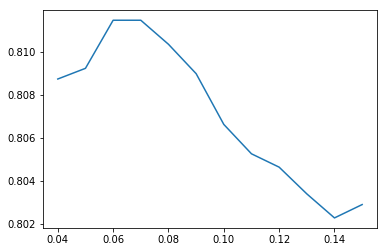

<Figure size 432x288 with 0 Axes>

In [55]:
import matplotlib.pyplot as plt    
                    
plt.plot(ccc, c_scores)
plt.show()


# Let's test this baby out!

In [25]:
tweets_list = [i[1]["content"] for i in tweets.iterrows()]
rating_list = [i[1]["rating"] for i in tweets.iterrows()]

In [26]:
import re

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
NO_SPACE = ""
SPACE = " "

def preprocess_reviews(reviews):
    
    reviews = [REPLACE_NO_SPACE.sub(NO_SPACE, line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line) for line in reviews]
    
    return reviews

twitter_cleaned = preprocess_reviews(tweets_list)


In [27]:
stop_words = stopwords.words('english')
ngram_vectorizer_tweets = CountVectorizer(binary=True, ngram_range=(1, 3), stop_words=stop_words)
ngram_vectorizer_tweets.fit(twitter_cleaned)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [28]:
tws = ngram_vectorizer.transform(twitter_cleaned)
tws.shape


(101, 139447)

In [38]:
predictions = final.predict(tws[:100])

In [39]:
pd.DataFrame({"Prediction": predictions, "Actual": rating_list[:100]}).reset_index(drop=True).head()

,Prediction,Actual
0,0,0
1,0,0
2,0,1
3,1,1
4,1,1


In [50]:
total = 0
score = 0
for i, j in zip(predictions, rating_list):
    total += 1
    if i == j:
        score += 1
        
print(f"Accuracy: {score/total}")

Accuracy: 0.7326732673267327


# Save & Load Model

In [31]:
from sklearn.externals import joblib

In [32]:
joblib.dump(final, "final_model_svc.pkl")

['final_model_svc.pkl']

In [33]:
try:
    retrieve_model = joblib.load("final_model_svc.pkl")
    print("using trained model")
except:
    print("model not found")
    joblib.dump(final, "final_model_svc.pkl")

using trained model


# Top Postitive and Negative Features

In [34]:
feature_to_coef = {
    word: coef for word, coef in zip(
        ngram_vectorizer.get_feature_names(), final.coef_[0]
    )
}

for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:30]:
    print (best_positive)
    
print("\n\n")
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:30]:
    print (best_negative)

('fuck', 0.8832945558863153)
('gay', 0.8122463917114521)
('bitch', 0.7562103615559161)
('emo', 0.7382007519789737)
('ass', 0.6480757091859153)
('fucking', 0.6377205726497154)
('loser', 0.6064767156785721)
('whore', 0.57811374929683)
('sucks', 0.5050615613122257)
('hate', 0.4846680212793077)
('nerd', 0.48216680884759816)
('cunt', 0.4799606801478932)
('damn', 0.46249661749476645)
('cock', 0.45851629935261573)
('fat', 0.43402001981305327)
('dick', 0.41371307481923575)
('slut', 0.3827450527853783)
('pig', 0.36331459098011065)
('ugly', 0.3390199966544164)
('freak', 0.336713106571376)
('pussy', 0.3234374309894383)
('piss', 0.2771399980657057)
('really sucks', 0.27165348215152046)
('fag', 0.26645479110648396)
('whale', 0.25463027808337624)
('wow', 0.23891221397136417)
('ur', 0.23192750507638524)
('suck', 0.21878501248329155)
('hoe', 0.20820565994153176)
('cum', 0.1830298385368222)



('ever', -0.25723081464809044)
('thanks', -0.2511597147008126)
('love', -0.22527421825648705)
('nope', -0.2216

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True)
cv.fit(reviews_train_clean)
X = cv.transform(reviews_train_clean)
X_test = cv.transform(reviews_test_clean)

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c, gamma)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))


SyntaxError: positional argument follows keyword argument (<ipython-input-36-7525c19e9dcc>, line 11)

In [ ]:
stop_words = stopwords.words('english')
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3), stop_words=stop_words)
ngram_vectorizer.fit(reviews_train_clean)
X = ngram_vectorizer.transform(reviews_train_clean)
X_test = ngram_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size = 0.75
)

for c in [0.001, 0.005, 0.01, 0.05, 0.1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))
    
final = LinearSVC(C=0.01)
final.fit(X, y)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final.predict(X_test)))

In [ ]:
from sklearn.metrics import classification_report
predictions = final.predict(X_test)
print(classification_report(y_test, predictions))